<a href="https://colab.research.google.com/github/envirodatascience/final-project-go-squirrels/blob/main/Meryl_Squirrels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**2018 Squirrels in Central Park: Fur Color, Busy Areas, and Squirrel Reactions**

#Introduction

Squirrels are one of the most common mammals in North America, but are rarely the subject of studies. They also are one of the few animals who thrive among humans in extremely urban environments. Our group is investigating how environmental factors correlate with squirrel composition and behavior in Central Park based on The Squirrel Census conducted in 2018.

"[The Squirrel Census](https://www.thesquirrelcensus.com/) is a multimedia science, design, and storytelling project focusing on the Eastern gray (Sciurus carolinensis). They count squirrels and present their findings to the public."

This notebook introduces the 2018 Squirrel Census data to the reader, plotting and mapping the distribution of squirrel fur color in Central Park. It also investigates Question 4: Is there a difference in squirrel counts by hectare based on how busy an area of Central Park is? This question connects to [research](https://www.bu.edu/writingprogram/journal/past-issues/issue-11/rademacher/) on how squirrels adjust to human presence, reducing avoidance in urban settings.

#Part 1: Import Packages

In [1]:
# Basic
import pandas as pd
import numpy as np

# Plotting
from plotnine import *
import plotnine
from mizani.formatters import scientific_format, percent_format, currency_format

# Stats
import statsmodels.api as sm
import scipy.stats as stats

# geo
import geopandas as gpd
from shapely.geometry import Polygon

#Part 2: Upload Data

Data Desciptions:
*   2018 Central Park Squirrel Census - Squirrel Data from [NYC open data](https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw/about_data). This data set provides the first official count of Central Park's squirrel population. In October 2018, 323 volunteers went out over 11 days to count the number of squirrels in an assigned hectare. "This table contains squirrel data for each of the 3,023 sightings, including location coordinates, age, primary and secondary fur color, elevation, activities, communications, and interactions between squirrels and with humans."

*   2018 Central Park Squirrel Census - Hectare Data from [Data.gov data catalog](https://catalog.data.gov/dataset/2018-central-park-squirrel-census-hectare-data). "This table contains environmental data related to each of the 350 “countable” hectares of Central Park. Examples include weather, litter, animals sighted, and human density."
*   2018 Central Park Squirrel Census - Hectare Grid from [NYC open data](https://data.cityofnewyork.us/dataset/2018-Central-Park-Squirrel-Census-Hectare-Grid/qad5-y26n/about_data). "This dataset is the hectare grid that was used to divide Central Park for the 2018 Squirrel Census."
*   Central Park Boundary Polygon was created by Zaya using GIS. Central Park Buildings and Central Park Water Features were filtered by Zaya.

In [2]:
#2018 Squirrel Census
url = 'https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20250408.csv'
df_sq = pd.read_csv(url)
df_sq.head()


,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


In [3]:
#2018 Squirrel Census Hectare Data
link = 'https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/2018_Central_Park_Squirrel_Census_-_Hectare_Data_20250421.csv'
df_hect = pd.read_csv(link)
df_hect.head()

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting
0,01A,AM,10072018,110.0,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0
1,01A,PM,10142018,177.0,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0
2,01B,AM,10122018,11.0,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0
3,01B,PM,10192018,109.0,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0
4,01C,PM,10132018,241.0,"55° F, Partly Cloudy",NaN,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0


In [4]:
#2018 Squirrel Census Hectare Grid
! wget https://github.com/envirodatascience/final-project-go-squirrels/raw/refs/heads/main/2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip


--2025-04-28 13:54:31--  https://github.com/envirodatascience/final-project-go-squirrels/raw/refs/heads/main/2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip [following]
--2025-04-28 13:54:31--  https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16837 (16K) [application

In [5]:
! ls

2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip  sample_data


In [6]:
! unzip 2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip

Archive:  2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip
  inflating: geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.dbf  
  inflating: geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.cpg  
  inflating: geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.shp  
  inflating: geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.shx  
  inflating: geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.prj  


In [7]:
! ls

2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.cpg
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.dbf
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.prj
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.shp
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.shx
sample_data


In [8]:
shape = "geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.shp"
df_grid = gpd.read_file(shape)

In [9]:
df_grid.head()

,id,xmin,xmax,ymin,ymax,geometry
0,82.0,989030.73113,989358.81512,231243.27134,231571.35533,"POLYGON ((-73.95816 40.80102, -73.95713 40.800..."
1,83.0,989358.81512,989686.89911,231243.27134,231571.35533,"POLYGON ((-73.95713 40.80059, -73.95609 40.800..."
2,84.0,989686.89911,990014.98310,231243.27134,231571.35533,"POLYGON ((-73.95609 40.80015, -73.95505 40.799..."
3,85.0,990014.98310,990343.06709,231243.27134,231571.35533,"POLYGON ((-73.95505 40.79971, -73.95401 40.799..."
4,86.0,990343.06709,990671.15108,231243.27134,231571.35533,"POLYGON ((-73.95401 40.79928, -73.95298 40.798..."


In [10]:
df_grid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        378 non-null    float64 
 1   xmin      378 non-null    float64 
 2   xmax      378 non-null    float64 
 3   ymin      378 non-null    float64 
 4   ymax      378 non-null    float64 
 5   geometry  378 non-null    geometry
dtypes: float64(5), geometry(1)
memory usage: 17.8 KB


<Axes: >

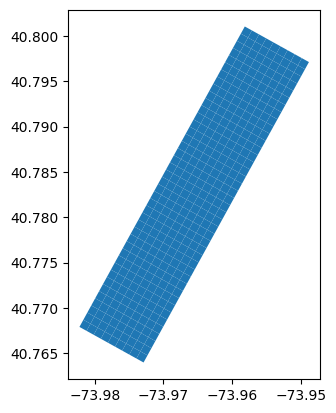

In [11]:
df_grid.plot()

In [12]:
#Central Park Polygon File
! wget https://github.com/envirodatascience/final-project-go-squirrels/raw/refs/heads/main/CentralParkPolygon.zip

--2025-04-28 13:54:34--  https://github.com/envirodatascience/final-project-go-squirrels/raw/refs/heads/main/CentralParkPolygon.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/CentralParkPolygon.zip [following]
--2025-04-28 13:54:34--  https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/CentralParkPolygon.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1558 (1.5K) [application/zip]
Saving to: ‘CentralParkPolygon.zip’

CentralParkPolygon. 100%[===================>]   1.52K  --.-KB/s    

In [13]:
! ls

2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip
CentralParkPolygon.zip
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.cpg
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.dbf
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.prj
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.shp
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.shx
sample_data


In [14]:
! unzip "CentralParkPolygon.zip"

Archive:  CentralParkPolygon.zip
  inflating: CentralParkPolygon.sbn  
  inflating: CentralParkPolygon.prj  
  inflating: CentralParkPolygon.dbf  
  inflating: CentralParkPolygon.cpg  
  inflating: CentralParkPolygon.shp  
  inflating: CentralParkPolygon.shx  


In [15]:
! ls

2018_Central_Park_Squirrel_Census_Hectare_Grid_20250427.zip
CentralParkPolygon.cpg
CentralParkPolygon.dbf
CentralParkPolygon.prj
CentralParkPolygon.sbn
CentralParkPolygon.shp
CentralParkPolygon.shx
CentralParkPolygon.zip
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.cpg
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.dbf
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.prj
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.shp
geo_export_ee808929-79e6-46ed-98a3-f98a9f8751f9.shx
sample_data


In [16]:
shape2 = 'CentralParkPolygon.shp'
df_park = gpd.read_file(shape2)

<Axes: >

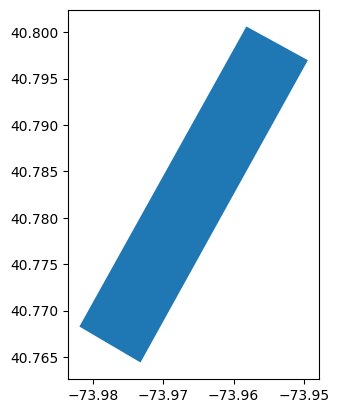

In [17]:
df_park.plot()

In [18]:
#Water Features in Central Park
url2 = 'https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/filtered_water.csv'
df_water = pd.read_csv(url2)
df_water.head()


,Unnamed: 0,the_geom,GISPROPNUM,OBJECTID,DEPARTMENT,PARENTID,COMMUNITYB,COUNCILDIS,PRECINCT,ZIPCODE,BOROUGH,NAME,WF_TYPE,FEATURESTA,index_right,Id
0,47,MULTIPOLYGON (((-73.95328479649801 40.79774801...,M010,911,M-13,M010,164.0,8.0,22.0,10025.0,M,NaN,NaN,Active,0,0
1,73,MULTIPOLYGON (((-73.98109367506895 40.76823933...,M010,1361,M-13,M010,NaN,NaN,NaN,NaN,NaN,NaN,Fountain,Active,0,0
2,93,MULTIPOLYGON (((-73.97176490440037 40.76793252...,M010,1049,M-13,M010,164.0,8.0,22.0,10023.0,M,NaN,NaN,Active,0,0
3,135,MULTIPOLYGON (((-73.96230904833098 40.78222341...,M010,912,M-13,M010,164.0,8.0,22.0,10024.0,M,NaN,NaN,Active,0,0
4,219,MULTIPOLYGON (((-73.96665388176177 40.77456933...,M010,915,M-13,M010,164.0,8.0,22.0,10023.0,M,NaN,NaN,Active,0,0


In [19]:
#Buildings in Central Park
url3 = 'https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/filtered_building.csv'
df_buildings = pd.read_csv(url3)
df_buildings.head()


,Unnamed: 0,the_geom,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID,index_right,Id
0,52254,MULTIPOLYGON (((-73.9711754290161 40.767876692...,Central Park-The Arsenal,1083811,1851.0,11/16/2020,Constructed,159673,77.000000,2100,45.0,0,0,1011110001,1011110001,Other (Man,{39C7E256-76CC-478A-9FB9-5F69A45BDF5F},0,0
1,52255,MULTIPOLYGON (((-73.96395111626312 40.78318848...,Central Park-22nd Police Precinct,1089496,1871.0,11/16/2020,Constructed,488697,16.000000,2100,112.0,0,0,1011110001,1011110001,Other (Man,{C8F7EBC6-4B27-427E-8ABD-405723147E22},0,0
2,52625,MULTIPOLYGON (((-73.95269085720317 40.79412134...,Conservatory Garden,1088629,1890.0,04/10/2020,Constructed,498921,10.660000,2100,24.0,0,0,1011110001,1011110001,Photogramm,{09E466FF-7888-4746-AA1D-6344AD82081E},0,0
3,52626,MULTIPOLYGON (((-73.95304441106086 40.79364016...,Conservatory Garden,1088622,1890.0,04/10/2020,Constructed,528145,10.256765,2100,26.0,0,0,1011110001,1011110001,Photogramm,{0D6FC0F8-4797-43E1-86BB-1C998679A945},0,0
4,60469,MULTIPOLYGON (((-73.97370768880343 40.76922216...,NaN,1083825,1871.0,03/04/2021,Constructed,493848,32.000000,2100,62.0,0,0,1011110001,1011110001,Other (Man,{6C952A6B-8590-44A2-81AC-97FDE6D76950},0,0


#Part 3: Clean and Transform Data

This sections helps us get familiar with the data, remove null values, transform select dataframes into geodataframes, and choose hectare features for further analyses.

In [20]:
#Familiarize with 2018 Squirrel Census
df_sq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   X                                           3023 non-null   float64
 1   Y                                           3023 non-null   float64
 2   Unique Squirrel ID                          3023 non-null   object 
 3   Hectare                                     3023 non-null   object 
 4   Shift                                       3023 non-null   object 
 5   Date                                        3023 non-null   int64  
 6   Hectare Squirrel Number                     3023 non-null   int64  
 7   Age                                         2902 non-null   object 
 8   Primary Fur Color                           2968 non-null   object 
 9   Highlight Fur Color                         1937 non-null   object 
 10  Combination 

In [21]:
df_sq['Primary Fur Color'].unique()

array([nan, 'Gray', 'Cinnamon', 'Black'], dtype=object)

In [22]:
df_sq['Highlight Fur Color'].unique()

array([nan, 'Cinnamon', 'White', 'Gray', 'Cinnamon, White', 'Gray, White',
       'Black, Cinnamon, White', 'Black', 'Black, White',
       'Black, Cinnamon', 'Gray, Black'], dtype=object)

In [23]:
df_sq['Combination of Primary and Highlight Color'].unique()

array(['+', 'Gray+', 'Gray+Cinnamon', 'Cinnamon+White', 'Gray+White',
       'Cinnamon+Gray', 'Gray+Cinnamon, White', 'Cinnamon+Gray, White',
       'Gray+Black, Cinnamon, White', 'Cinnamon+', 'Black+', 'Gray+Black',
       'Black+White', 'Black+Cinnamon', 'Gray+Black, White',
       'Cinnamon+Black', 'Black+Gray', 'Gray+Black, Cinnamon',
       'Black+Cinnamon, White', 'Cinnamon+Black, White',
       'Black+Gray, White', 'Cinnamon+Gray, Black'], dtype=object)

In [24]:
#Drop NaN from primary fur color
df_sq = df_sq[df_sq['Primary Fur Color'].notnull()]

In [25]:
df_sq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2968 entries, 2 to 3022
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   X                                           2968 non-null   float64
 1   Y                                           2968 non-null   float64
 2   Unique Squirrel ID                          2968 non-null   object 
 3   Hectare                                     2968 non-null   object 
 4   Shift                                       2968 non-null   object 
 5   Date                                        2968 non-null   int64  
 6   Hectare Squirrel Number                     2968 non-null   int64  
 7   Age                                         2867 non-null   object 
 8   Primary Fur Color                           2968 non-null   object 
 9   Highlight Fur Color                         1937 non-null   object 
 10  Combination of Pr

In [26]:
#Convert the Squirrel DataFrame to a GeoDataFrame
df_sq = gpd.GeoDataFrame(
    df_sq,
    geometry=gpd.points_from_xy(df_sq.X, df_sq.Y),
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

In [27]:
df_sq.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long,geometry
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083),POINT (-73.97428 40.77553)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029),POINT (-73.95964 40.79031)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894),POINT (-73.97027 40.77621)
5,-73.968361,40.772591,11H-AM-1010-03,11H,AM,10102018,3,Adult,Cinnamon,White,...,False,False,False,True,False,True,False,NaN,POINT (-73.9683613516225 40.7725908847499),POINT (-73.96836 40.77259)
6,-73.954120,40.793181,36H-AM-1010-02,36H,AM,10102018,2,Adult,Gray,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.9541201789795 40.7931811701082),POINT (-73.95412 40.79318)


<Axes: >

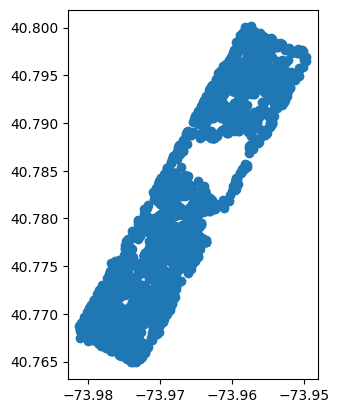

In [28]:
df_sq.plot()

In [29]:
#Transform water data into GeoDataFrame
# Import shapely.wkt
from shapely import wkt

# Apply wkt.loads to the 'the_geom' column to convert WKT strings to Shapely geometries
df_water['the_geom'] = df_water['the_geom'].apply(wkt.loads)

df_water = gpd.GeoDataFrame(df_water,
    geometry='the_geom',
    crs="EPSG:4326")

<Axes: >

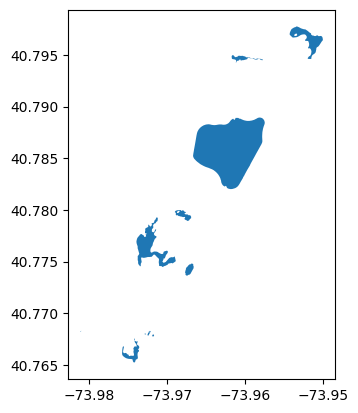

In [30]:
df_water.plot()

In [31]:
#Transform building data into GeoDataFrame
# Apply wkt.loads to the 'the_geom' column to convert WKT strings to Shapely geometries
df_buildings['the_geom'] = df_buildings['the_geom'].apply(wkt.loads)

df_buildings = gpd.GeoDataFrame(df_buildings,
    geometry='the_geom',
    crs="EPSG:4326")

<Axes: >

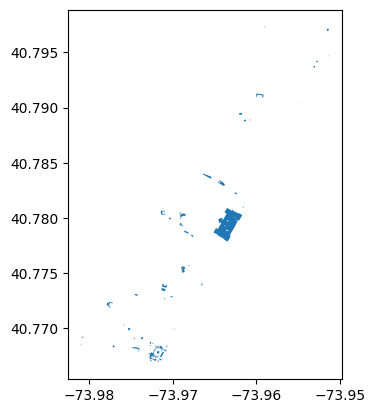

In [32]:
df_buildings.plot()

In [33]:
#Familiarize with 2018 Squirrel Census Hectare Data and select attributes for analysis
df_hect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Hectare                        700 non-null    object 
 1   Shift                          700 non-null    object 
 2   Date                           700 non-null    int64  
 3   Anonymized Sighter             700 non-null    float64
 4   Sighter Observed Weather Data  681 non-null    object 
 5   Litter                         319 non-null    object 
 6   Litter Notes                   6 non-null      object 
 7   Other Animal Sightings         668 non-null    object 
 8   Hectare Conditions             660 non-null    object 
 9   Hectare Conditions Notes       74 non-null     object 
 10  Number of sighters             700 non-null    int64  
 11  Number of Squirrels            700 non-null    int64  
 12  Total Time of Sighting         680 non-null    flo

In [54]:
#Examine Other Animal Sightings to see if it can be used for analysis
df_hect['Other Animal Sightings'].unique()

array(['Humans, Pigeons', 'Humans, Dogs, Pigeons, Horses',
       'Humans, Dogs, Pigeons, Sparrow, Blue jay',
       'Humans, Dogs, Pigeons, Birds', 'Humans', 'Humans, Dogs, Ducks',
       'Humans, Dogs, Cats, Raccoons',
       'Humans, Dogs, Pigeons, Ducks, Bluejay, Sparrow, Starling',
       'Humans, Pigeons, Small birds', 'Humans, Dogs',
       'Humans, Dogs, Pigeons, Downy Woodpecker, Sparrows',
       'Humans, Small birds', 'Humans, Hawks, Dogs',
       'Humans, Pigeons, Mice', 'Humans, Pigeons, Ducks, Geese', nan,
       'Humans, Dogs, Birds', 'Humans, Dogs (off-leash)', 'Humans, Birds',
       'Humans, Dogs, Pigeons',
       'Humans, Dogs, Ducks, Cardinal, Small birds, Robin',
       'Humans, Dogs, Birds, but not pigeons', 'Humans, Dogs, Sparrows',
       'Humans, Dogs, Blue Jays', 'Humans, Dogs, Small birds, Dogs',
       'Humans, Dogs, Birds, Song birds and Crows',
       'Humans, Dogs, Pigeons, Rat',
       'Humans, Dogs, Sparrows, Starlings, American robins',
       'Humans,

In [35]:
df_hect['Other Animal Sightings'].nunique()

263

Since there is no standard documentation for the other animals column and >200 different unique entries, we're not going to evaluate its impact on squirrel distribution at this time. Future work could clean up the information and create a new column to show which hectares had dogs or not, for example.

In [36]:
#Examine Hectare Conditions for analysis
df_hect['Hectare Conditions'].unique()

array(['Busy', 'Calm', nan, 'Moderate', 'Calm, Busy', 'Medium'],
      dtype=object)

In [37]:
df_hect['Hectare Conditions'].value_counts()

,count
Hectare Conditions,
Busy,362
Calm,253
Moderate,26
"Calm, Busy",18
Medium,1


Hectare conditions has a manageable number of unique values. This column defines the conditions as busy calm, moderate, calm/busy, and medium. There is no official documentation from the Squirrel Census project on what exactly these categories mean. However, there is nearly a 50/50 split between the Busy and Calm value counts, and we will carry forward with an analysis under the assumption that busy hectares have noticeably more foot traffic and movement than the calm hectares.

We will filter for busy and calm areas and then create a dummy variable for a conditions score for each hectare where busy = 1 and calm = 0. We will then look at whether or not the conditions score affects the total number of squirrels in that hectare.

In [38]:
#Filter dataset for Busy and Calm areas
df_hect_filtered = df_hect[(df_hect['Hectare Conditions'] == 'Busy')|(df_hect['Hectare Conditions']== 'Calm')]
df_hect_filtered['Hectare Conditions'].value_counts()

,count
Hectare Conditions,
Busy,362
Calm,253


In [39]:
df_hect_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 698
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Hectare                        615 non-null    object 
 1   Shift                          615 non-null    object 
 2   Date                           615 non-null    int64  
 3   Anonymized Sighter             615 non-null    float64
 4   Sighter Observed Weather Data  606 non-null    object 
 5   Litter                         300 non-null    object 
 6   Litter Notes                   6 non-null      object 
 7   Other Animal Sightings         602 non-null    object 
 8   Hectare Conditions             615 non-null    object 
 9   Hectare Conditions Notes       49 non-null     object 
 10  Number of sighters             615 non-null    int64  
 11  Number of Squirrels            615 non-null    int64  
 12  Total Time of Sighting         605 non-null    float64


In [40]:
#Create Dummy Variables for Busy and Calm Areas
df_hect_filtered['Conditions Score'] = np.where(df_hect_filtered['Hectare Conditions']=='Calm', 0, 1)
df_hect_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 698
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Hectare                        615 non-null    object 
 1   Shift                          615 non-null    object 
 2   Date                           615 non-null    int64  
 3   Anonymized Sighter             615 non-null    float64
 4   Sighter Observed Weather Data  606 non-null    object 
 5   Litter                         300 non-null    object 
 6   Litter Notes                   6 non-null      object 
 7   Other Animal Sightings         602 non-null    object 
 8   Hectare Conditions             615 non-null    object 
 9   Hectare Conditions Notes       49 non-null     object 
 10  Number of sighters             615 non-null    int64  
 11  Number of Squirrels            615 non-null    int64  
 12  Total Time of Sighting         605 non-null    float64


<ipython-input-40-37d6446ecf51>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
#Check work
df_hect_filtered['Conditions Score'].value_counts()

,count
Conditions Score,
1,362
0,253


In addition to total squirrels in each hectare we will look at how many squirrels run from, approach, or are indifferent to the surveyor's presence in busy and calm hectares.

In [56]:
# Group by hectare and sum the boolean values for each behavior
hectare_totals = df_sq.groupby('Hectare').agg(
    {'Runs from': 'sum', 'Approaches': 'sum', 'Indifferent': 'sum'}
).reset_index()

hectare_totals


,Hectare,Runs from,Approaches,Indifferent
0,01A,3,0,6
1,01B,0,1,23
2,01C,2,1,1
3,01D,0,0,9
4,01E,0,1,4
...,...,...,...,...
333,42E,2,0,4
334,42F,1,0,5
335,42G,4,1,2
336,42H,3,0,2


In [57]:
# Merge hectare_totals with df_hect_filtered on 'Hectare' column
merged_df = pd.merge(hectare_totals, df_hect_filtered, on='Hectare', how='inner')
merged_df.head()


,Hectare,Runs from,Approaches,Indifferent,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,Conditions Score
0,01A,3,0,6,AM,10072018,110.0,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0,1
1,01A,3,0,6,PM,10142018,177.0,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0,1
2,01B,0,1,23,AM,10122018,11.0,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0,1
3,01B,0,1,23,PM,10192018,109.0,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0,1
4,01C,2,1,1,PM,10132018,241.0,"55° F, Partly Cloudy",NaN,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0,1


In [72]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Hectare                        597 non-null    object 
 1   Runs from                      597 non-null    int64  
 2   Approaches                     597 non-null    int64  
 3   Indifferent                    597 non-null    int64  
 4   Shift                          597 non-null    object 
 5   Date                           597 non-null    int64  
 6   Anonymized Sighter             597 non-null    float64
 7   Sighter Observed Weather Data  588 non-null    object 
 8   Litter                         294 non-null    object 
 9   Litter Notes                   6 non-null      object 
 10  Other Animal Sightings         586 non-null    object 
 11  Hectare Conditions             597 non-null    object 
 12  Hectare Conditions Notes       48 non-null     obj


#Part 4: Visual Introduction to the 2018 Squirrel Census Results -- Plotting and Mapping Squirrels Based on Fur Color and Reactions to Surveyors

This section introduces us to the results of the 2018 Squirrel Census to provide people with a snapshot of the 2018 squirrel population in Central Park.

When Eastern gray squirrels (Sciurus carolinensis) breed, they can develop genetic variations that lead to different fur colors, like black or cinnamon, diverging from their typical grey coats. In both rural and urban environmentas, "exhibit color morphs (physical forms) easily recognizable to untrained observers. The color morphs develop from variation in eumelanin and
phaeomelanin production regulated by the melanocortin-1 receptor gene (Mc1R)" ([Gibbs et al., 2019](https://link.springer.com/chapter/10.1007/978-3-030-11259-2_12)).

Ecologists theorize that the black morph used to be much more common in North America when there were old growth forests--the black morphs could more easily camouflage in the dark, dense, conifer-heavy woods. Now, secondary forests with more deciduous trees have replaced the old growth, and in rural areas, the grey coated squirrel has a better chance of survival, blending into the greyish color of the bark to avoid predators. However, with the [in-breeding and lack of predators in urban spaces](https://www.nytimes.com/2001/04/05/nyregion/for-squirrels-cinnamon-is-now-the-new-black.html), cinnamon and black furred squirrels are commonly spotted in big Eastern cities like NYC and Philadelphia.

In [42]:
#Value count
df_sq['Primary Fur Color'].value_counts()

,count
Primary Fur Color,
Gray,2473
Cinnamon,392
Black,103


In [43]:
#Percentage black squirrels
103/(2473+392+103)*100

3.4703504043126685

In [44]:
#Percentage red squirrels
392/(2473+392+103)*100

13.20754716981132

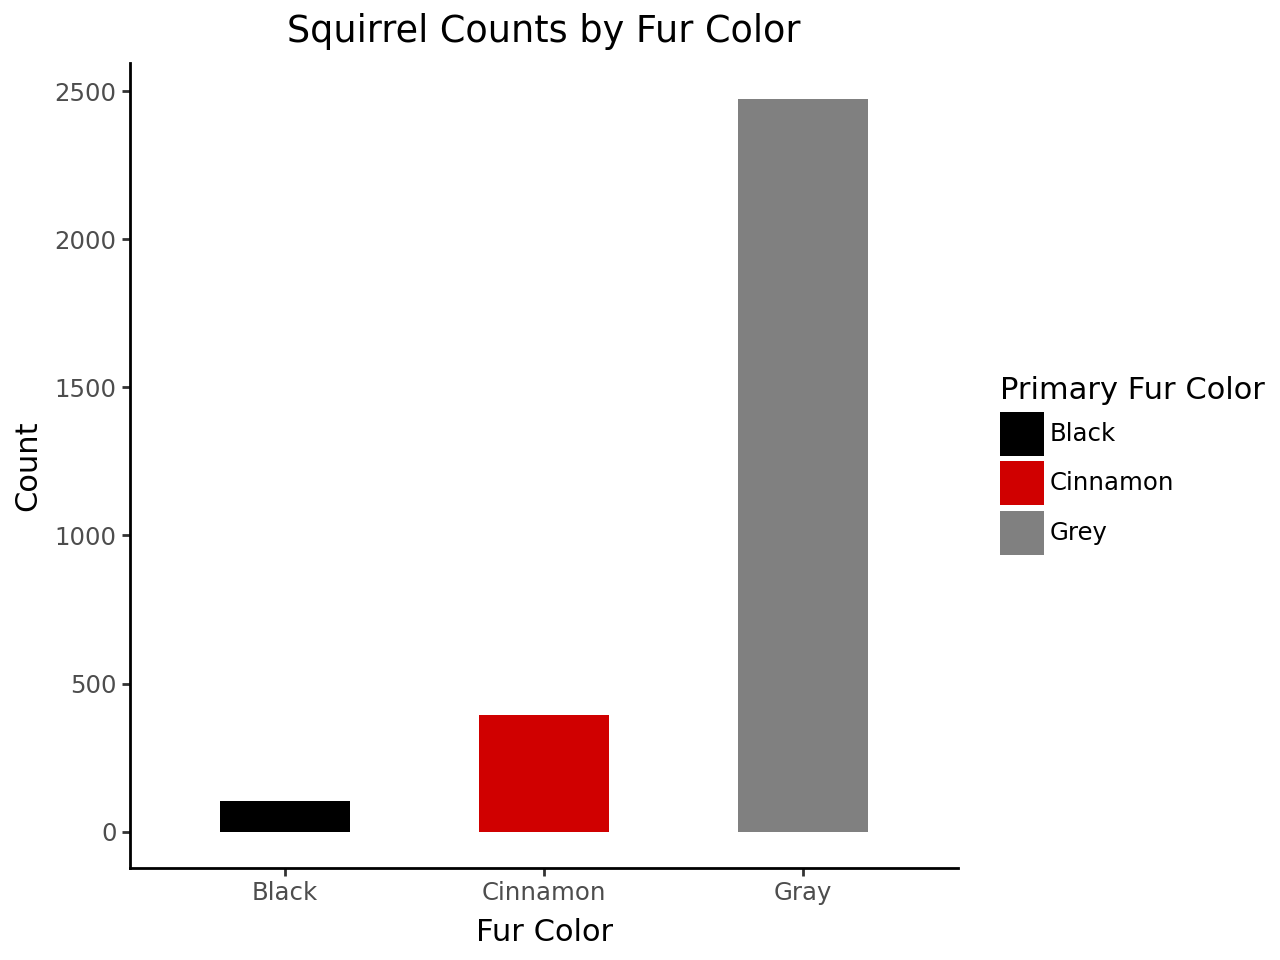

In [45]:
# Create Histogram of Squirrel Fur Color
(
    ggplot(df_sq, aes(x='Primary Fur Color', fill='Primary Fur Color'))
    + geom_bar(width=0.5)
    + scale_fill_manual(values=['black', '#d00000', 'grey'], labels=['Black', 'Cinnamon', 'Grey'])
    + theme_classic()
    + labs(title="Squirrel Counts by Fur Color", x="Fur Color", y="Count")
)

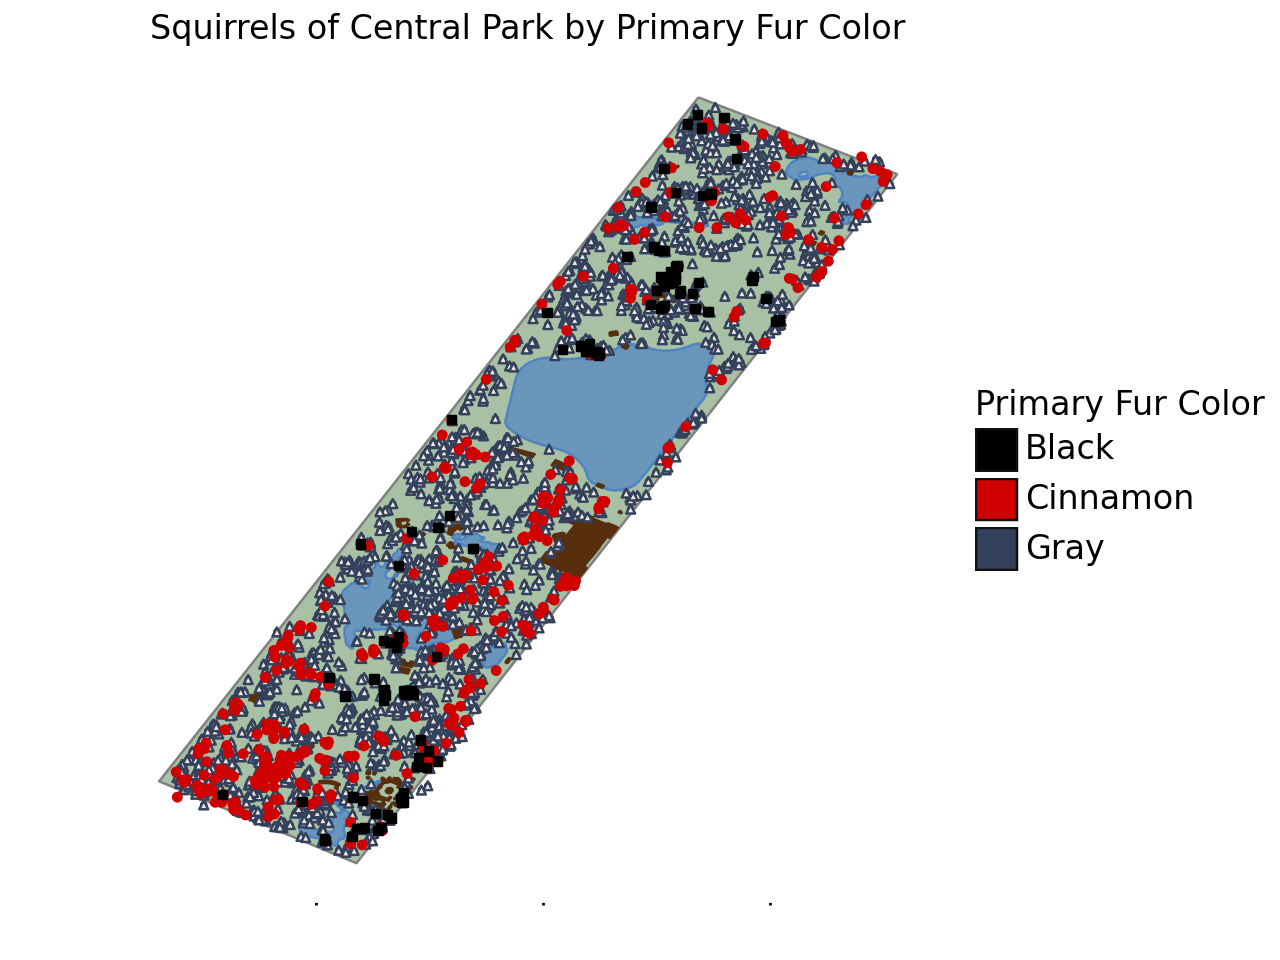

In [46]:
#Map squirrels based on color
(
    ggplot(df_sq)
    + geom_map(aes(fill="Primary Fur Color"))
    + scale_fill_manual(values = ('black', '#d00000', '#33415c'))
    + geom_map(df_park, aes(geometry='geometry'), fill="#52854C", color='grey', alpha=0.5)
    + geom_map(df_water, aes(geometry='the_geom'), fill="#4E84C4", color="#4E84C4", alpha=0.7)
    + geom_map(df_buildings, aes(geometry='the_geom'), fill="#582f0e", color="#582f0e")
    + geom_map(df_sq[df_sq['Primary Fur Color'] == 'Gray'], aes(x='X', y='Y', geometry='geometry'), shape='^', size=1.3, fill='#f2e9e4', color='#33415c')
    + geom_map(df_sq[df_sq['Primary Fur Color'] == 'Cinnamon'], aes(x='X', y='Y', geometry='geometry'), shape='o', size=1.2, fill="#d00000", color="#d00000")
    + geom_map(df_sq[df_sq['Primary Fur Color'] == 'Black'], aes(x='X', y='Y', geometry='geometry'), shape='s', size=1.2, fill='black', color='black')
    + theme_classic()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"),
            axis_text=element_line(color='white'),
            text=element_text(size = 12))
    + labs(title="Squirrels of Central Park by Primary Fur Color", fill='Primary Fur Color')
    + xlab("")
    + ylab("")
)

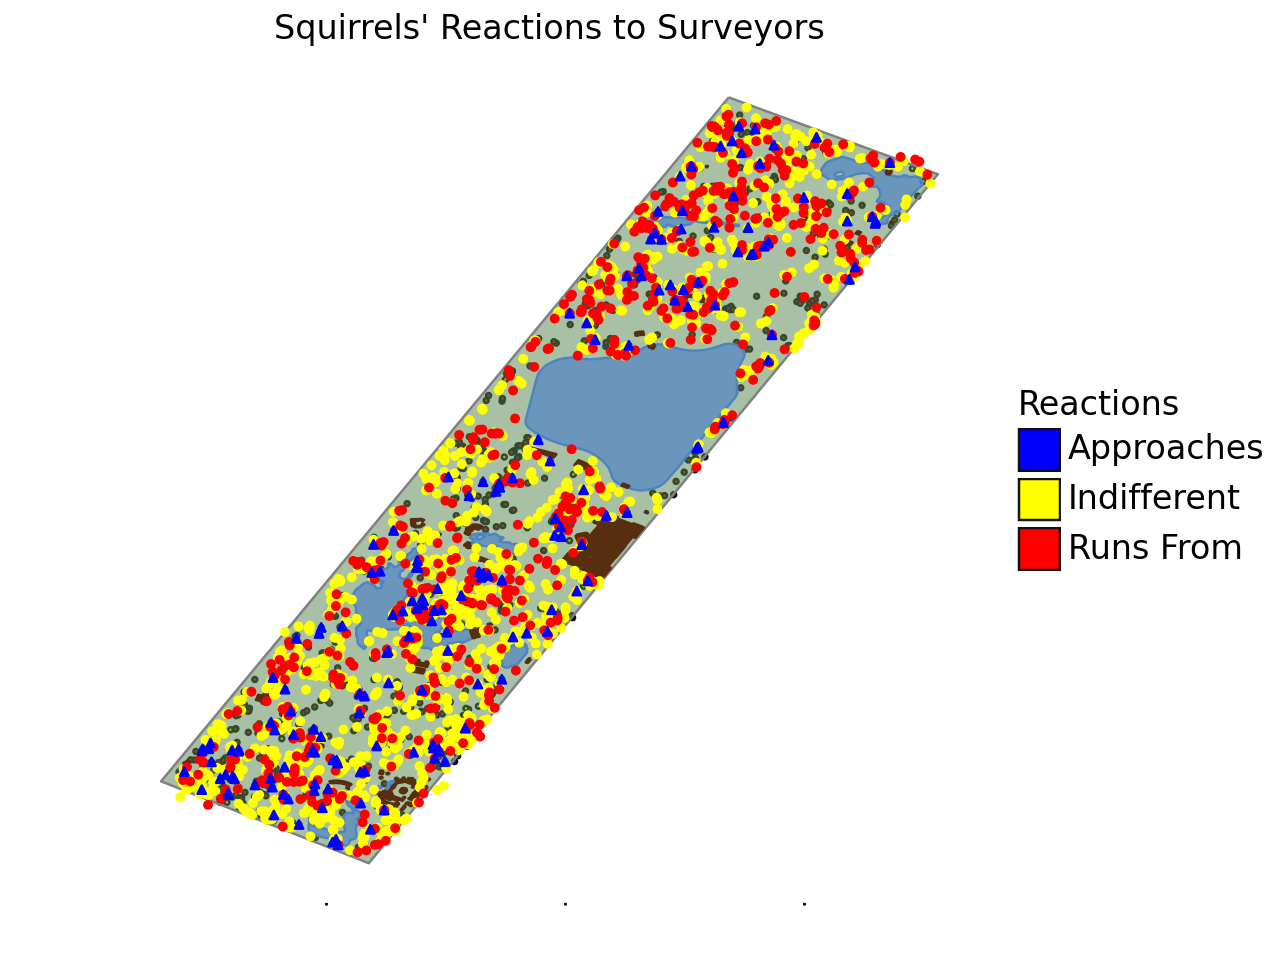

In [61]:
#Map Squirrels based on indifferent or run from
(
    ggplot(df_sq)
    + geom_map(aes(fill='Primary Fur Color'))
    + scale_fill_manual(values = ('blue', 'yellow', 'red'), labels = ('Approaches', 'Indifferent', 'Runs From'))
    + geom_map(df_park, aes(geometry='geometry'), fill="#52854C", color='grey', alpha=0.5)
    + geom_map(df_water, aes(geometry='the_geom'), fill="#4E84C4", color="#4E84C4", alpha=0.7)
    + geom_map(df_buildings, aes(geometry='the_geom'), fill="#582f0e", color="#582f0e")
    + geom_map(df_sq[df_sq['Indifferent'] == 1], aes(x='X', y='Y', geometry='geometry'), shape='o', size=1, fill="yellow", color="yellow")
    + geom_map(df_sq[df_sq['Runs from'] == 1], aes(x='X', y='Y', geometry='geometry'), shape='o', size=1, fill="red", color="red")
    + geom_map(df_sq[df_sq['Approaches'] == 1], aes(x='X', y='Y', geometry='geometry'), shape='^', size=1.2, fill='blue', color='blue')
    + theme_classic()
    + theme(axis_line=element_line(color="white"),
            axis_ticks=element_line(color = "white"),
            axis_text=element_line(color='white'),
            text=element_text(size = 12))
    + labs(title="Squirrels' Reactions to Surveyors", fill='Reactions')
    + xlab("")
    + ylab("")
)

In urban areas, squirrels adapt to be less avoidant to humans--exhibiting indifference or even at times approaching humans in search of food.

#Part 5: Hectare Conditions and Squirrel Count

This section looks at whether the hectare conditions (busy or calm) correlate with the total squirrel counts.

[Research](https://www.bu.edu/writingprogram/journal/past-issues/issue-11/rademacher/) suggests that squirrels can get used to human presence and associate them with food and decreased predator pressure. In urban environments, squirrels are more likely to co-habitate with humans and exhibit decreased avoidance. We will see if the increased presence of humans in busy areas correlates with total squirrel counts for that hectare.

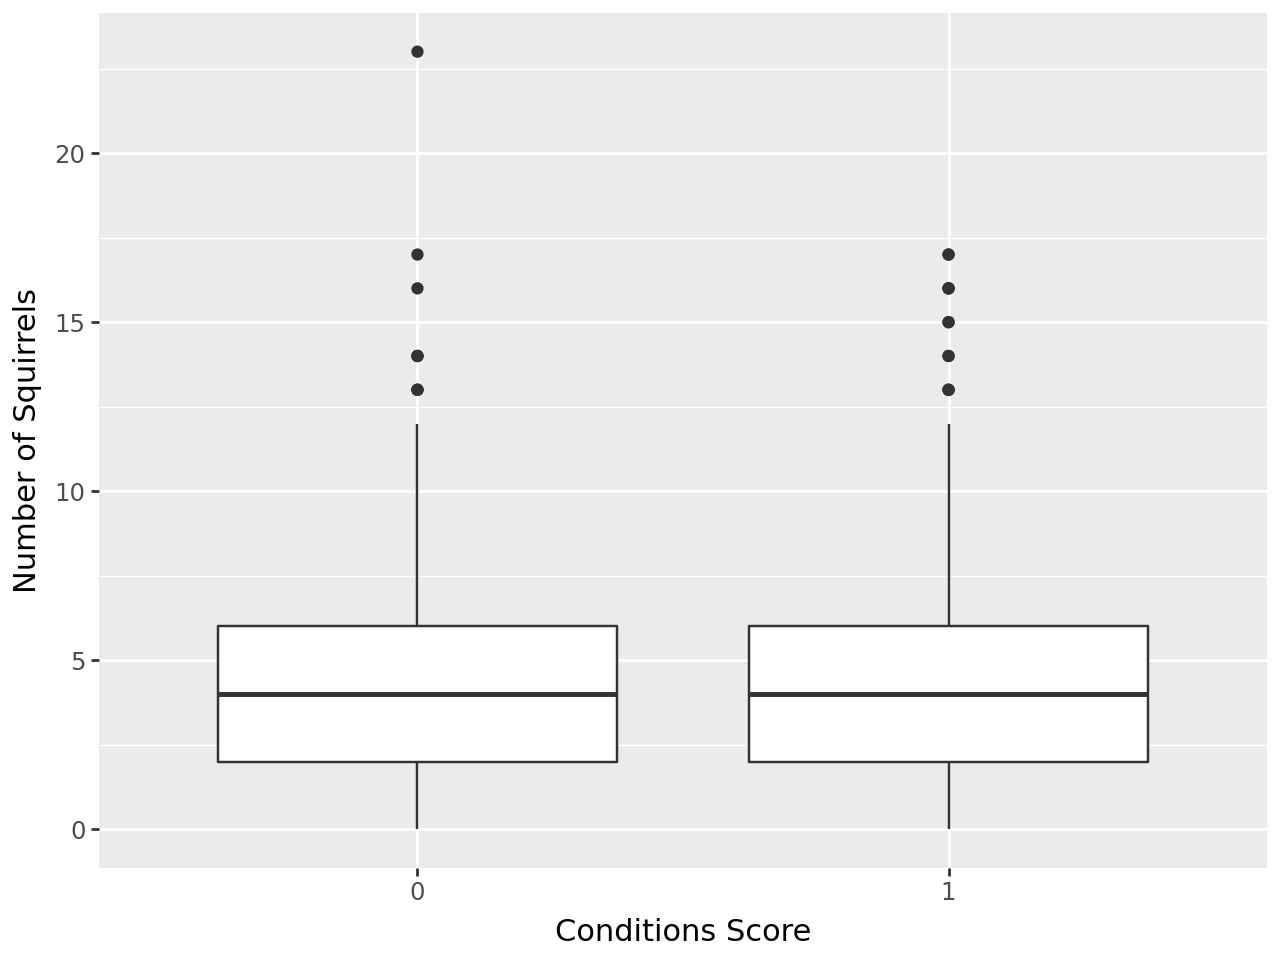

In [49]:
#High level look at Conditions and Squirrel Count
df_chart = df_hect_filtered.copy()
df_chart['Conditions Score'] = df_chart['Conditions Score'].astype('str')

(
    ggplot(df_chart, aes(x='Conditions Score', y='Number of Squirrels'))
    + geom_boxplot()
)

In [50]:
#Summarize further and check standard deviations
df_hect_filtered.groupby('Conditions Score').agg(value_count = ('Conditions Score', 'count'),
                                                 avg_sq_number = ('Number of Squirrels', 'mean'),
                                                 max_sq = ('Number of Squirrels', 'max'),
                                                 min_sq = ('Number of Squirrels', 'min'),
                                                 std = ('Number of Squirrels', 'std'))

,value_count,avg_sq_number,max_sq,min_sq,std
Conditions Score,,,,,
0,253,4.470356,23,0,3.658556
1,362,4.232044,17,0,3.547270


In [51]:
#Create variables for t-test and double check standard deviations
sq_busy = df_hect_filtered[df_hect_filtered['Conditions Score'] == 1]['Number of Squirrels']
sq_calm = df_hect_filtered[df_hect_filtered['Conditions Score'] == 0]['Number of Squirrels']

#Double Check Standard Deviations
print(sq_busy.std())
print(sq_calm.std())

3.547270140483327
3.658555784528737


Since the standard deviations are close, let's try a t-test!

In [52]:
#Run T-Test
stats.ttest_ind(sq_busy, sq_calm)

TtestResult(statistic=np.float64(-0.8093048096806779), pvalue=np.float64(0.41865385259005217), df=np.float64(613.0))

The p value is > 0.05 indicating that there is no statistically significant difference in the number of squirrels in a hectare based on whether the area is classified as busy or calm.

*Logistic Regression*

In [62]:
# Define Variables
X = sm.add_constant(df_hect_filtered['Number of Squirrels'])
Y = df_hect_filtered['Conditions Score']

# Define model
model = sm.Logit(Y, X)

# Fit model
model_result = model.fit()

# print results
print(model_result.summary2())

Optimization terminated successfully.
         Current function value: 0.676826
         Iterations 4
                          Results: Logit
Model:               Logit             Method:            MLE     
Dependent Variable:  Conditions Score  Pseudo R-squared:  0.001   
Date:                2025-04-28 14:41  AIC:               836.4960
No. Observations:    615               BIC:               845.3392
Df Model:            1                 Log-Likelihood:    -416.25 
Df Residuals:        613               LL-Null:           -416.57 
Converged:           1.0000            LLR p-value:       0.41871 
No. Iterations:      4.0000            Scale:             1.0000  
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------
const                0.4383   0.1288  3.4040 0.0007  0.1859 0.6906
Number of Squirrels -0.0184   0.0227 -0.8095 0.4182 -

Like the T-Test, the p value is > 0.05 indicating that there is no statistically significant difference in the number of squirrels in a hectare based on whether the area is classified as busy or calm. The lack of relationship between these variables is in line with the research that shows that urban squirrels have adapted to human presence. It makes sense that their total numbers would not differ based on the busy/calm conditions in the area.

#Part 6: Hectare Conditions and Squirrel Reactions

Now, we'll look at the squirrels' reactions to surveyors by hectare conditions. Question: Are there any visible trends between the squirrels reactions to the surveyors and the hectare conditions? Since each hectare was evaluated once in the morning and once in the evening, we will separate the results into AM and PM.

In [79]:
#Create dataframe for reactions to surveyors by hectare conditions in the morning
df_react_AM = merged_df[merged_df.Shift== 'AM'].groupby('Hectare Conditions').agg(approaches = ('Approaches', 'sum'),
                                            indifferent = ("Indifferent", 'sum'),
                                            runs_from = ('Runs from', 'sum'),
                                            total=('Hectare Conditions', 'count')).reset_index()
df_react_AM

,Hectare Conditions,approaches,indifferent,runs_from,total
0,Busy,76,618,253,154
1,Calm,88,701,343,152


In [81]:
df_react_PM = merged_df[merged_df.Shift== 'PM'].groupby('Hectare Conditions').agg(approaches = ('Approaches', 'sum'),
                                            indifferent = ("Indifferent", 'sum'),
                                            runs_from = ('Runs from', 'sum'),
                                            total = ('Hectare Conditions', 'count')).reset_index()
df_react_PM

,Hectare Conditions,approaches,indifferent,runs_from,total
0,Busy,112,816,371,194
1,Calm,39,402,208,97


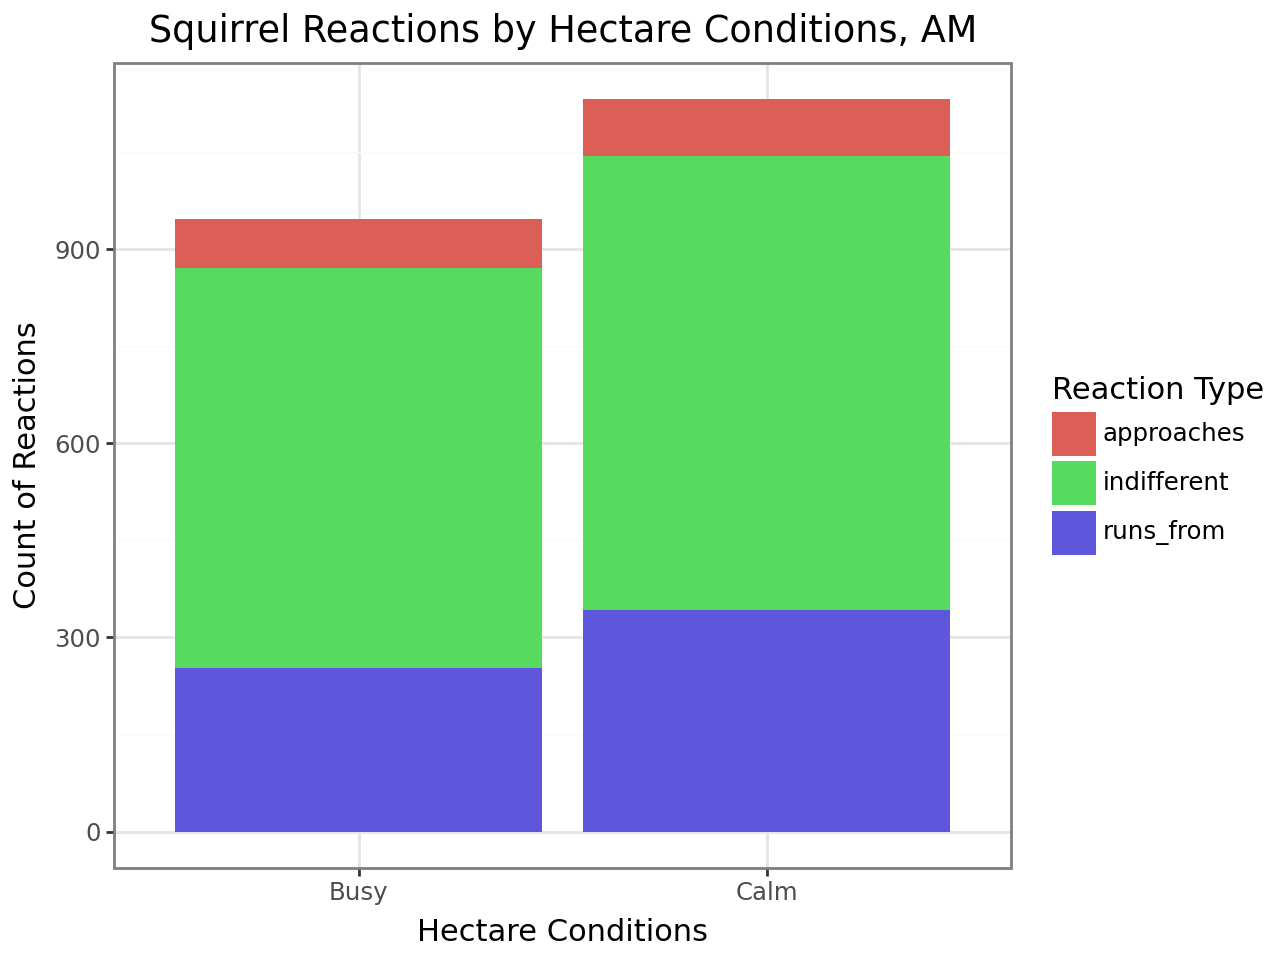

In [76]:
# Create a stacked bar chart with the values for approaches, indifferent and runs from
# by hectare conditions in the morning
# Melt df_react_AM
df_react_AM_long = pd.melt(df_react_AM, id_vars='Hectare Conditions',
                        value_vars=['approaches', 'indifferent', 'runs_from'],
                        var_name='Reaction', value_name='Count')
#Create stacked bar chart
(ggplot(df_react_AM_long, aes(x='Hectare Conditions', y='Count', fill='Reaction'))
 + geom_bar(stat='identity', position='stack')
 + labs(title='Squirrel Reactions by Hectare Conditions, AM',
        x='Hectare Conditions',
        y='Count of Reactions',
        fill='Reaction Type')
 + theme_bw()
)


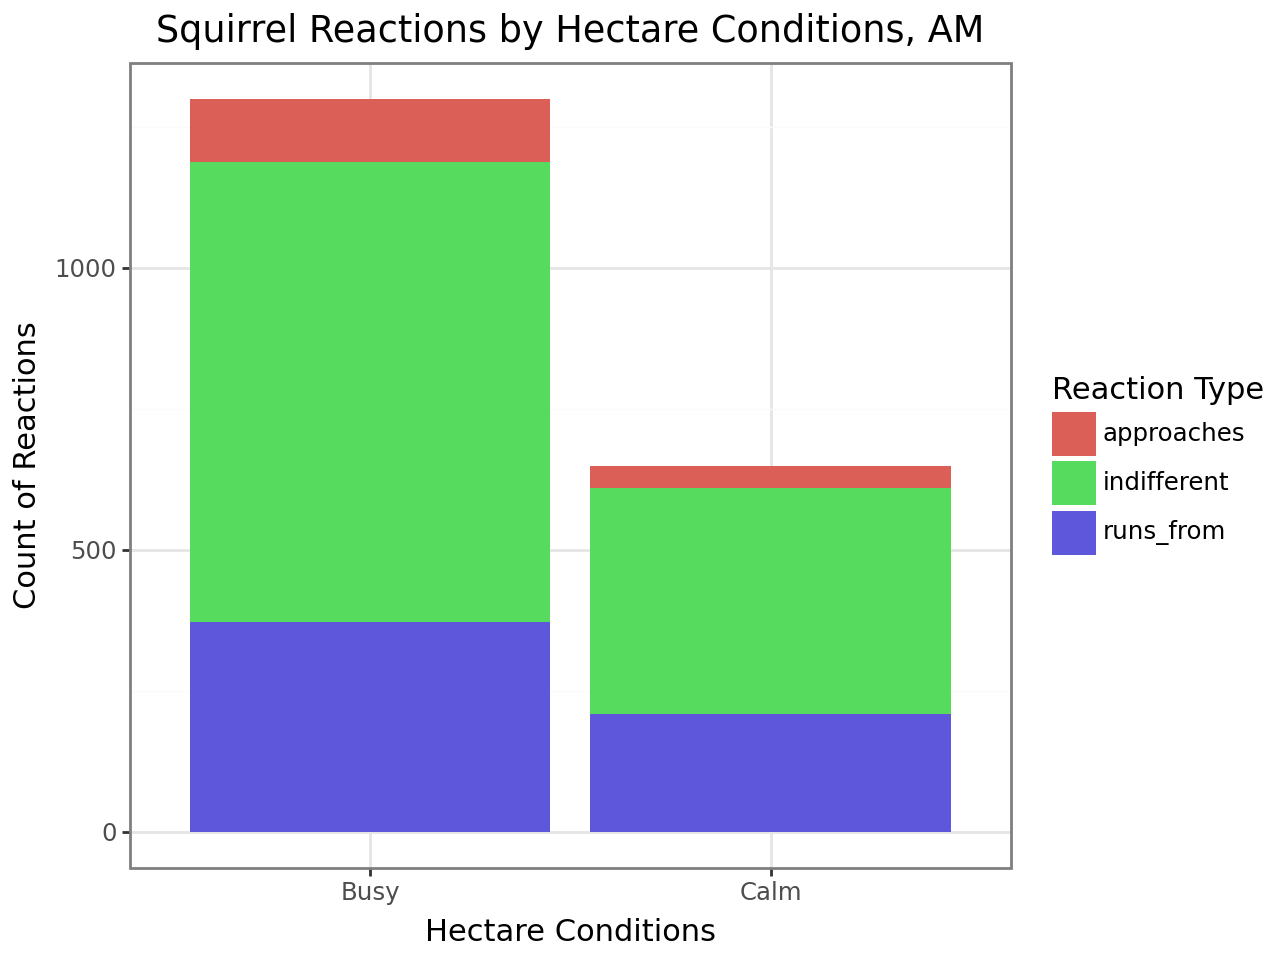

In [77]:
#Repeat for PM
# Melt df_react_PM
df_react_PM_long = pd.melt(df_react_PM, id_vars='Hectare Conditions',
                        value_vars=['approaches', 'indifferent', 'runs_from'],
                        var_name='Reaction', value_name='Count')
#Create stacked bar chart
(ggplot(df_react_PM_long, aes(x='Hectare Conditions', y='Count', fill='Reaction'))
 + geom_bar(stat='identity', position='stack')
 + labs(title='Squirrel Reactions by Hectare Conditions, AM',
        x='Hectare Conditions',
        y='Count of Reactions',
        fill='Reaction Type')
 + theme_bw()
)


These plots do not show statistical relationships--the values are not standardized. In the AM, there are near equal hectares classified as busy and calm whereas in the evening, there are nearly double the amount of busy hectares as there are calm hectares. The plots give us an idea of the distribution of the squirrels' reactions to surveyors. Their overwhelming indifference speaks to their adaptation to human presence in an urban environment.

#Part 7: Concluding Thoughts
This notebook introduces us to the fur color and reactions of Central Park's 2018 squirrels. There is seemingly no relationship between the busy/calm conditions of the survey hectares and the total squirrel count in those hectares. Overall, this work aligns with previous studies that have shown the ability of the Eastern Grey squirrel to adapt to human presence in urban environments.

I'd recommend additional analysis, normalizing the squirrel reactions in the busy and calm conditions or creating a dummy variable for squirrel reactions to better understand how squirrel reactions differ based on the hectare conditions.

My analyses were limited by the one-time nature of this dataset, and I struggled to find additional datasets that pertained to Central Park and squirrels. I was also limited by time.

Further data collection could be done, repeating the efforts of the 2018 census to see if there have been any changes over time. Trends in urban-adapted animals can be useful for considering how humans and climate change impact ecosystems.